# Proyecto Semestral: Hito I

## Importar librerías

In [2]:
library(ggplot2)
# install.packages("corrgram")
library(corrgram)
# library(GGally)
# install.packages("dplyr")
library(dplyr)
# install.packages("reshape")
library(reshape)
# install.packages("plotly", dependencies = TRUE)
# library(plotly)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename




## Introducción
El presente reporte tiene el objetivo de dar a conocer el conjunto de datos con los que se trabajará a lo largo del semestre, además de realizar distintos tipos de análisis gráficos que aporten información valiosa dirigida a cumplir con las motivaciones y objetivos generales del proyecto.

### Base de datos

Para el proyecto se utilizará un set de datos basado en la demanda de reserva en ciertos hoteles. Estos datos fueron extraídos desde la página kaggle. Estos contienen información con respecto a la reservación de hoteles, ya sea resort o en la ciudad durante los años 2015-2017. Entre la información incluida se tiene la fecha en la que fue hecha la reservación, el tiempo de estadía, la distribución de los clientes que reservan ( el número de adultos, niños y bebés) y el número de estacionamientos disponibles, entre otras cosas.
  

In [3]:
df = read.table(file = 'https://raw.githubusercontent.com/sebastianflp/DataMiningDCC/main/hotel_bookings.csv', as.is = F, sep = ',', header = TRUE)
head(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,⋯,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<int>,<int>,<fct>,<fct>
1,Resort Hotel,0,342,2015,July,27,1,0,0,2,⋯,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,737,2015,July,27,1,0,0,2,⋯,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
3,Resort Hotel,0,7,2015,July,27,1,0,1,1,⋯,No Deposit,NULL,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,13,2015,July,27,1,0,1,1,⋯,No Deposit,304,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,⋯,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,14,2015,July,27,1,0,2,2,⋯,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03


### Motivación del Proyecto

Considerando los datos anteriormente expuestos sería de interés utilizarlos para poder predecir o calcular la probabilidad de que una persona cualquiera termine cancelando su reservación y así generar un perfil de este tipo de personas con el objetivo de poder ofrecerle reagendar o alguna solución que permita mantener al cliente interesado en utilizar este servicio y así reducir pérdidas.

## Análisis exploratorio de datos

### Reemplazo de valores nulos
Para comenzar, en la base de datos existen valores indefinidos escritos como string. Por lo que estas celdas se reemplazan con NA's, con el fin de facilitar su tratamiento.

In [4]:
# Undefined
df$meal[df$meal == 'Undefined'] = NA
df$market_segment[df$market_segment == 'Undefined'] = NA
df$distribution_channel[df$distribution_channel == 'Undefined'] = NA

# NULL
df$country[df$country == 'NULL'] = NA
df$agent[df$agent == 'NULL'] = NA
df$company[df$company == 'NULL'] = NA

A continuación analizaremos el conjunto de datos usando técnicas de análisis exploratorio de datos. El objetivo es encontrar características relevantes que puedan afectar el desarrollo del proyecto y/o la validación de nuestra hipótesis. Primero, contemos el número de filas y columnas:

In [5]:
dim(df)

[1] 119390     32

En total son 119.390 filas y 32 columnas. Nos gustaría poder estudiar el comportamiento de dichas variables, para esto haremos un $\textit{summary}$  de las más relevantes para el análisis.

In [6]:
summary(df %>% select(company, children, country, agent, reservation_status, is_canceled))

    company          children          country          agent      
 40     :   927   Min.   : 0.0000   PRT    :48590   9      :31961  
 223    :   784   1st Qu.: 0.0000   GBR    :12129   240    :13922  
 67     :   267   Median : 0.0000   FRA    :10415   1      : 7191  
 45     :   250   Mean   : 0.1039   ESP    : 8568   14     : 3640  
 153    :   215   3rd Qu.: 0.0000   DEU    : 7287   7      : 3539  
 (Other):  4354   Max.   :10.0000   (Other):31913   (Other):42797  
 NA's   :112593   NA's   :4         NA's   :  488   NA's   :16340  
 reservation_status  is_canceled    
 Canceled :43017    Min.   :0.0000  
 Check-Out:75166    1st Qu.:0.0000  
 No-Show  : 1207    Median :0.0000  
                    Mean   :0.3704  
                    3rd Qu.:1.0000  
                    Max.   :1.0000  
                                    

En específico, en la siguiente celda se muestran las variables que presentan valores perdidos o nulos

En Kaggle aparece:
* children
* country
* agent
* company

In [8]:
tmp = sapply(df, function(x) sum(is.na(x)))
df_na = data.frame(variable=names(tmp), conteo=tmp)
df_na["porcentaje"] = round(df_na$conteo / nrow(df) * 100, 4)
row.names(df_na) <- NULL
table1 <- head(df_na[order(desc(df_na$conteo)),], 7)

png("tab1.png", height=250, width=320)
p<-tableGrob(table1)
grid.arrange(p)
dev.off()

table1

png 
  2

,variable,conteo,porcentaje
,<chr>,<int>,<dbl>
25,company,112593,94.3069
24,agent,16340,13.6862
13,meal,1169,0.9791
14,country,488,0.4087
16,distribution_channel,5,0.0042
11,children,4,0.0034
15,market_segment,2,0.0017


Notemos que la variable $\textit{company}$ tiene casi $94,3\%$ de sus filas en NULL. Esto da motivos para no considerar esta columna debido a la cantidad de valores faltantes. Además, la columna children, que nos dice cuantos niños son considerados dentro de la reserva tiene 4 valores NA, también faltantes.

### Transforma a factores, numéricos y fechas
Para poder visualizar de manera correcta los datos, se debe formatear algunas variables que no encajan con sus descripciones correpondientes.

In [9]:
df$is_canceled = as.factor(df$is_canceled)
df$arrival_date_day_of_month = as.factor(df$arrival_date_day_of_month)
df$arrival_date_week_number = as.factor(df$arrival_date_week_number)
df$reservation_status_date = as.Date(df$reservation_status_date)
df$is_repeated_guest = as.factor(df$is_repeated_guest)
df$agent = as.factor(df$agent)
df$company = as.factor(df$company)
df$arrival_date_month <- factor(df$arrival_date_month, levels = c('January', 'February', 'March', 'April',  'May', 'June', 'July', 'August', 'September', 'October','November', 'December' ))

### Estudio del tipo de datos de las variables

Tras haber transformado las variables a su representación real, nos gustaría saber la composición de los tipos de datos del dataset.

png 
  2

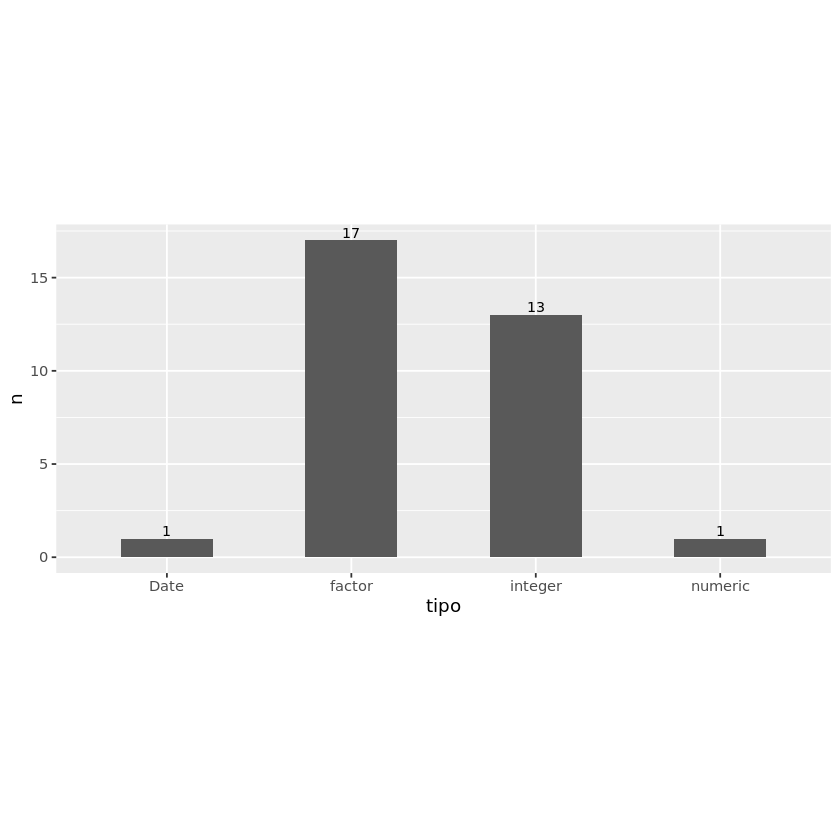

In [10]:
data_types <- function(frame) {
  res <- lapply(frame, class)
  res_frame <- data.frame(tipo=unlist(res))
  res_frame <- res_frame %>% group_by(tipo) %>% summarise(n=n())
  ggplot(res_frame, aes(x=tipo, y=n)) + geom_col(width=.5) + geom_text(label=res_frame$n, vjust = -0.25, size=3) + theme(aspect.ratio = 0.45)
  # barplot(table(res_frame), main="Data Types", col="steelblue", ylab="Number of Features")
}
dat_types <- data_types(df)

png("dat_types.png")
print(dat_types)
dev.off()

dat_types

En la grafica anterior se puede apreciar la distribución en los tipo de las categorías siendo predominantes las de tipo "integer"

### ¿Está balanceada la variable de interés?

Sobre todo en un proyecto en que se busca clasificar, es necesario disponer de un dataset balanceado. Esto quiere decir que la cantidad de datos de cada categoría dispongan de cantidades relativamente similares o razonables. 

El problema que puede ocurrir cuando no hay datos balanceados, es que el evento de interés, en este caso, que una reserva sea cancelado, sea predecido erroneamente, sin embargo, la bondad de ajuste (accuracy) sea considerablemente buena, dado que hay muchos datos de la otra categoría que son correctamente clasificados en comparación a la otra categoría.

png 
  2

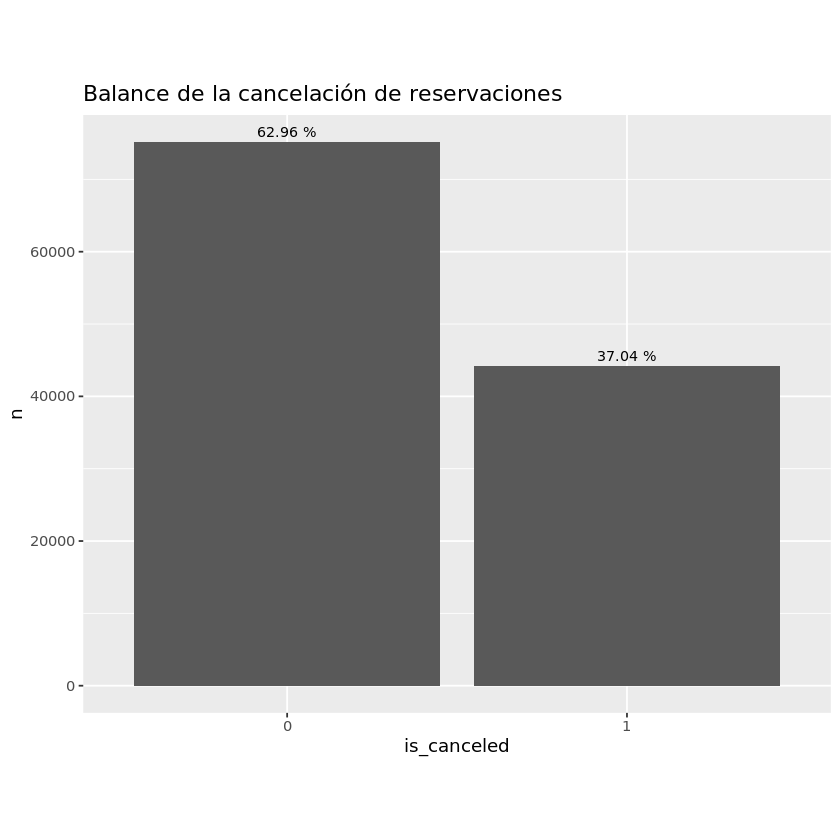

In [11]:
df_bal = df %>% group_by(is_canceled) %>% summarise(n=n())
df_bal["perc"] = paste(as.character(round(df_bal$n / sum(df_bal$n) * 100, 2)), "%")
balance <- ggplot(df_bal, aes(x=is_canceled, y=n))+
    geom_col()+
    ggtitle("Balance de la cancelación de reservaciones")+
    geom_text(label=c(df_bal$perc), vjust=-0.5, size=3)+theme(aspect.ratio = 0.8)
    png("balance.png")
    print(balance)
    dev.off()

balance

Notemos que hay una diferencia significativa entre ambos datos, sin embargo, es discutible si es que esta diferencia puede generar problemas en la predicción. Es necesario revisar la literatura para aclarar esto.

### Cómo se comportan los clientes en los distintos meses
Para responder esta pregunta primero se mira la cantidad de reservas totales por mes

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


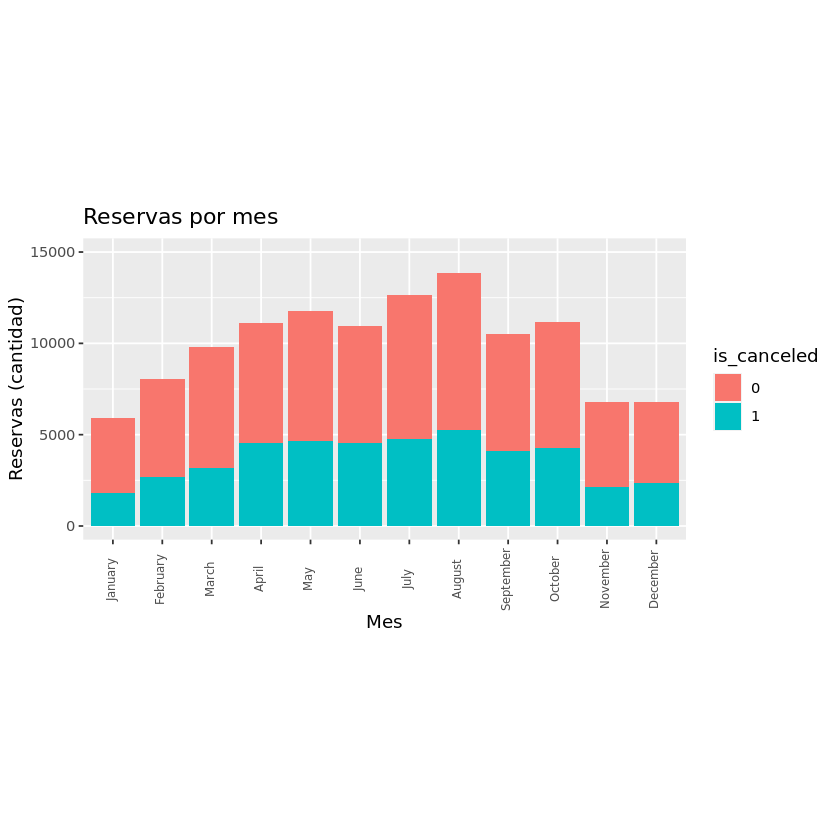

In [129]:
ggplot(df, aes(x=arrival_date_month, fill=is_canceled)) +
    geom_histogram(stat="count") +
    theme(aspect.ratio = 0.5, axis.text.x = element_text(size = 7, angle = 90, vjust=0.2)) +
    ggtitle("Reservas por mes") + ylim(c(0,15000)) + xlab("Mes") + ylab("Reservas (cantidad)")
#plot(df$arrival_date_month, ylim=c(0,15000), main="Reservas por Mes", xlab="Mes", ylab="Reservas(cantidad)")

In [ ]:
# canceled <- df[df$is_canceled == 1,]
# ggplot(canceled, aes(x=arrival_date_month)) +
#     geom_histogram(stat="count", position="dodge2") +
#     theme(aspect.ratio = 0.5, axis.text.x = element_text(size = 7, angle = 90)) +
#     ggtitle("Cancelaciones por mes") + ylim(c(0,15000)) + xlab("Mes") + ylab("Cancelaciones (cantidad)")

Se ve que los peaks se forman en los meses de julio y agosto, que en este caso, dado que los hoteles están ubicados en Portugal, coinciden con las vacaciones de verano.

Además, se puede apreciar, como era de esperarse, que las cancelaciones tienen una distribución similar a la vista en las reservaciones en total.

### ¿Cómo se distribuyen las reservaciones según el tipo de hotel?

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


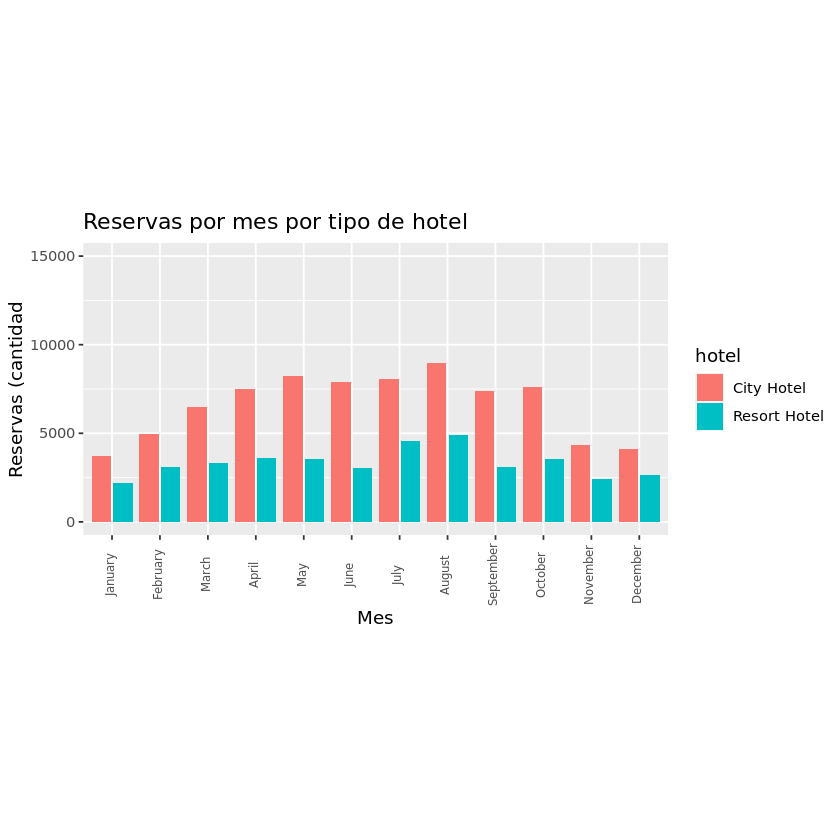

In [128]:
ggplot(df, aes(x=arrival_date_month, fill=hotel)) +
    geom_histogram(stat="count", position="dodge2") + ylim(c(0,15000)) +
    theme(aspect.ratio = 0.5, axis.text.x = element_text(size = 7, angle = 90, vjust=0.2)) +
    ggtitle("Reservas por mes por tipo de hotel") + xlab("Mes") + ylab("Reservas (cantidad")

In [84]:
data.frame(summary(df$hotel))

,summary.df.hotel.
,<int>
City Hotel,79330
Resort Hotel,40060


Según el gráfico y tabla se aprecia que se cuenta con más registros para el hotel de ciudad, que para el resort.

### ¿Quiénes son los clientes?

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


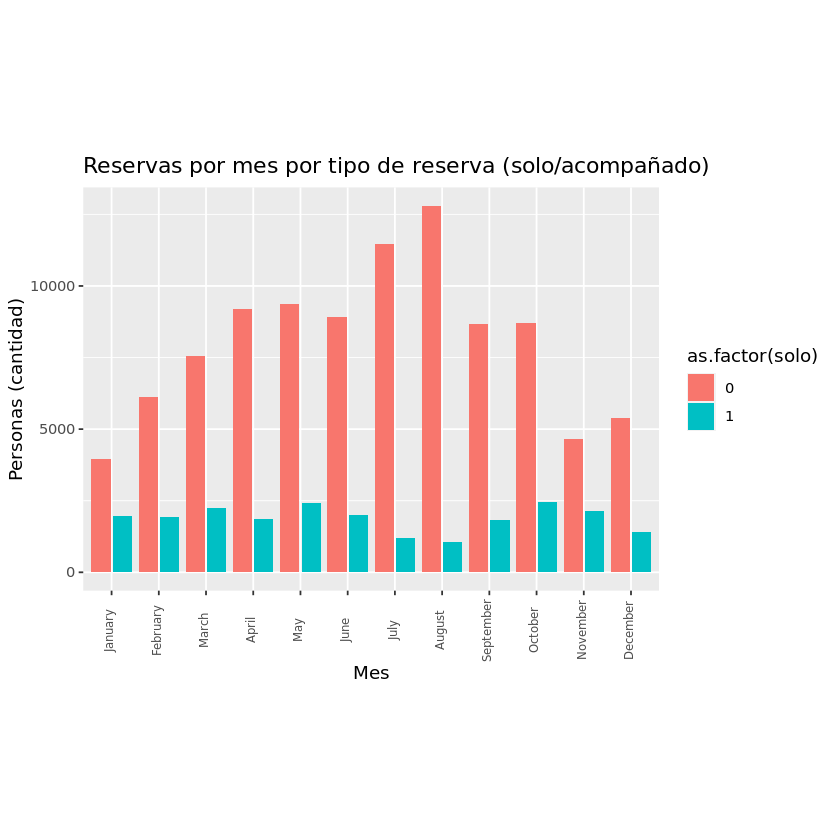

In [157]:
tmp <- data.frame(df)
tmp['solo'] = ifelse(tmp$children == 0 & tmp$babies == 0 & tmp$adults==1, 1, 0)
# tmp$solo = factor(tmp$solo, labels=c(1, 0), levels=c("solo", "acompañado"))
ggplot(tmp, aes(x = arrival_date_month, fill=as.factor(solo))) +  
  geom_histogram(stat="count", position="dodge2") + xlab("Mes") + ylab("Personas (cantidad)") +
  ggtitle("Reservas por mes por tipo de reserva (solo/acompañado)") +
  theme(aspect.ratio = 0.7, axis.text.x = element_text(size = 7, angle = 90, vjust=0.2))

In [ ]:
# df$ninos = df$children + df$babies
# c<-aggregate(ninos ~ arrival_date_month, df, FUN=sum)
# c$arrival_date_month <- factor(c$arrival_date_month, levels = c('January', 'February', 'March', 'April',  'May', 'June', 'July', 'August', 'September', 'October','November', 'December' ))

# ggplot(c) +  
#   geom_bar(aes(x = arrival_date_month, y=ninos), stat="identity") +   
#   coord_flip() +  
#   ggtitle("Reservas de Familias con Hijos") + 
#   xlab("Mes") + ylab("Reservas (cantidad)") 

### Varianzas por variable
A continuación se muestra un gráfico de barras con las varianzas asociadas a todas las variables numéricas. Esto se realiza con el fin de identificar las variables que podrían aportar variabilidad a un modelo, así como las que no lo harían.

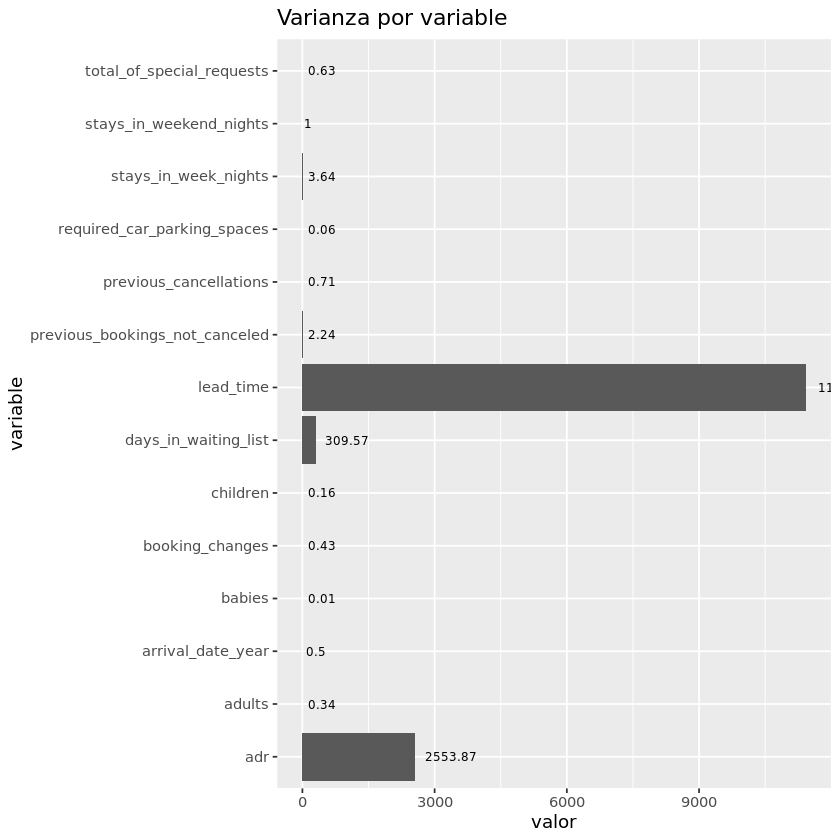

In [15]:
df_numerico = df[,unlist(lapply(df, is.numeric))]
tmp = sapply(df_numerico, function(x) var(na.omit(x)))
df_var = data.frame(variable=names(tmp), valor=tmp)

# png('var_gral.png')
ggplot(df_var, aes(x = variable, y = valor)) + geom_col() +
    geom_text(label=round(df_var$valor, 2), hjust=-0.2, size=2.5) + coord_flip() +
    ggtitle("Varianza por variable")
# dev.off()

In [16]:
df_var['lead_time', 'valor']

[1] 11419.72

### ¿Qué son las variables con mayor varianza?
* lead_time: corresponde a la diferencia de tiempo en días desde que una persona agenda su reservación, hasta la fecha en que reserva.

* adr (Average Daily Rate): se calcula como la división entre la suma de todas las transacciones de alojamiento, por el número total de noches de estancia.

* days_in_waiting_list: corresponde a la cantidad de días desde que se realiza una reservación, hasta que se confirma la confirmación al cliente.

Dado el alto valor de la varianza del lead time, el ADR y los días en lista de espera, no se puede visualizar el comportamiento de las demás variables, por lo tanto, en el siguiente bloque se muestra el mismo gráfico quitando las varianzas mayores a 200.

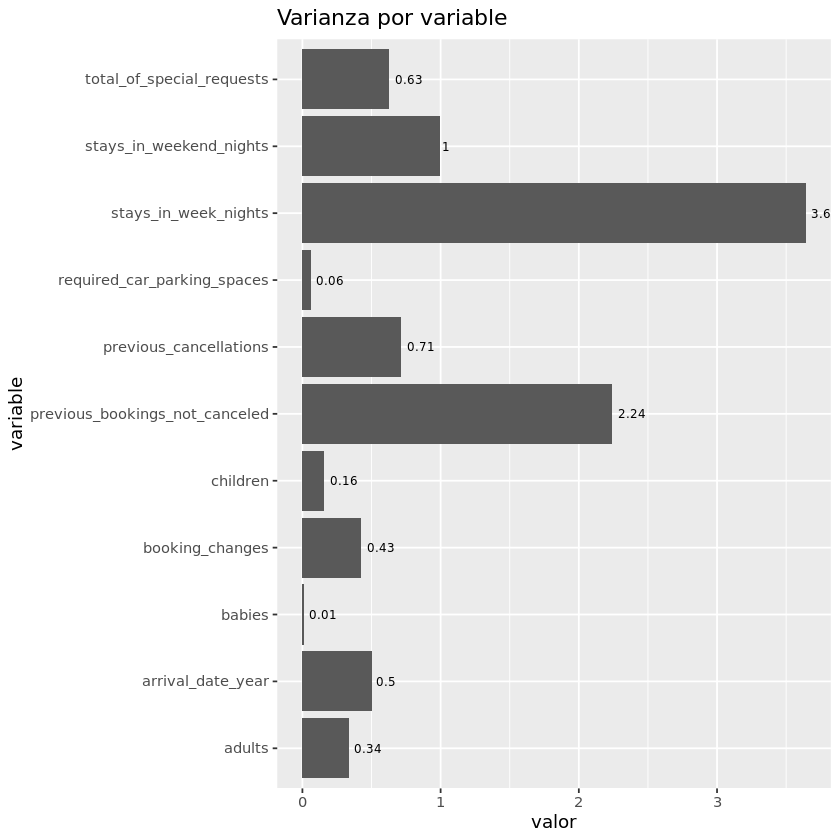

In [17]:
# png('var_menor_200.png')
tmp = df_var[df_var$valor < 200,]
ggplot(tmp, aes(x = variable, y = valor)) + geom_col() +
    geom_text(label=round(tmp$valor, 2), hjust=-0.2, size=2.5) + coord_flip()+
    ggtitle("Varianza por variable")
# dev.off()

In [18]:
df_var['stays_in_week_nights', 'valor']

[1] 3.641554

De este gráfico se puede apreciar que las variables que menos aportan variabilidad son la cantidad de bebés y la cantidad de espacios de estacionamientos requeridos. La tercer menor variable corresponde a la cantidad de niños/as.

### Correlación entre variables
En la siguiente celda se muestra la matriz de correlaciones de las variables numéricas del dataframe. Esta correlación es calculada con el método de Pearson.

In [161]:
df_cor

,lead_time,arrival_date_year,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,as.numeric(df$is_canceled),as.numeric(df$reservation_status)
lead_time,1.0000000000,0.04009272,0.085667112,0.165799474,0.119544317,-0.037621678,-0.020917916,0.086039838,-0.073552180,0.0001380965,0.170082604,-0.06312600,-0.11646051,-0.09568783,0.293177384,-0.302229174
arrival_date_year,0.0400927219,1.00000000,0.021488846,0.030877957,0.029674197,0.054624164,-0.013197135,-0.119833108,0.029214349,0.0308552231,-0.056506374,0.19751838,-0.01369900,0.10858511,0.016732493,-0.017755741
stays_in_weekend_nights,0.0856671122,0.02148885,1.000000000,0.498967239,0.091888610,0.045792937,0.018482550,-0.012775390,-0.042716302,0.0632801821,-0.054152569,0.04932328,-0.01855557,0.07268600,-0.001783382,0.008550753
stays_in_week_nights,0.1657994743,0.03087796,0.498967239,1.000000000,0.092983373,0.044202919,0.020190920,-0.013993096,-0.048743688,0.0962095799,-0.002020421,0.06521945,-0.02486094,0.06819913,0.024771434,-0.021613676
adults,0.1195443171,0.02967420,0.091888610,0.092983373,1.000000000,0.030446849,0.018147811,-0.006735864,-0.107982949,-0.0516660388,-0.008280488,0.23069002,0.01479089,0.12285460,0.059990266,-0.071775576
children,-0.0376216776,0.05462416,0.045792937,0.044202919,0.030446849,1.000000000,0.024029552,-0.024730099,-0.021072490,0.0489488885,-0.033272616,0.32485360,0.05625285,0.08174482,0.005047790,-0.003410542
babies,-0.0209179156,-0.01319714,0.018482550,0.020190920,0.018147811,0.024029552,1.000000000,-0.007501283,-0.006550706,0.0834390248,-0.010620908,0.02918293,0.03738270,0.09789283,-0.032488454,0.030968032
previous_cancellations,0.0860398385,-0.11983311,-0.012775390,-0.013993096,-0.006735864,-0.024730099,-0.007501283,1.000000000,0.152727847,-0.0269938913,0.005928488,-0.06565315,-0.01849315,-0.04838200,0.110140471,-0.110765435
previous_bookings_not_canceled,-0.0735521797,0.02921435,-0.042716302,-0.048743688,-0.107982949,-0.021072490,-0.006550706,0.152727847,1.000000000,0.0116065130,-0.009397387,-0.07215141,0.04765236,0.03782706,-0.057355365,0.055048288
booking_changes,0.0001380965,0.03085522,0.063280182,0.096209580,-0.051666039,0.048948888,0.083439025,-0.026993891,0.011606513,1.0000000000,-0.011635469,0.01960225,0.06561749,0.05284417,-0.144370572,0.140788656


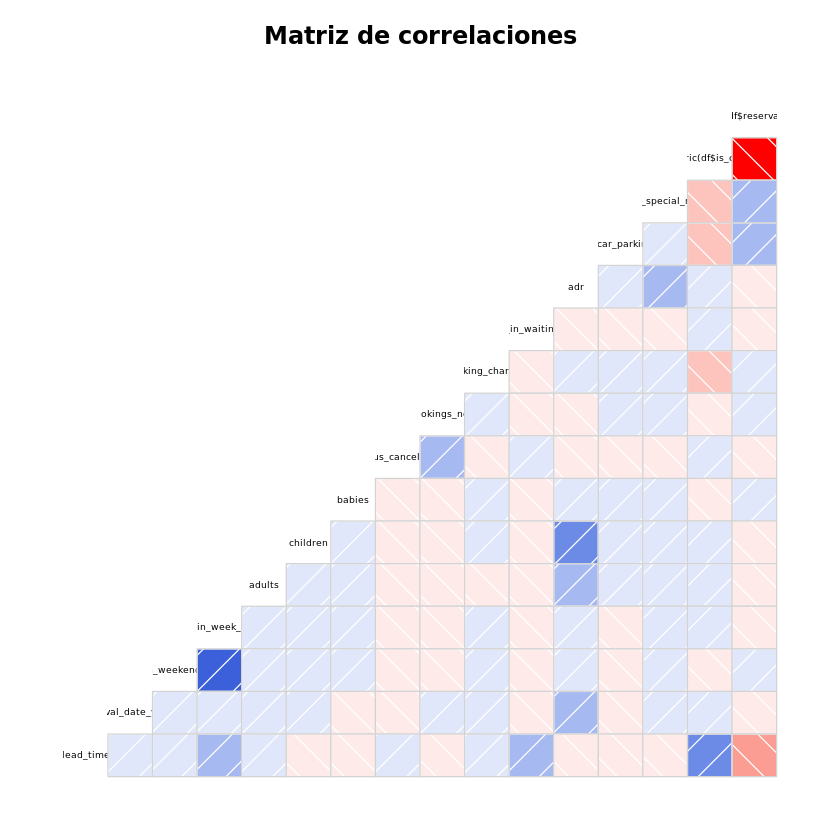

In [160]:
df_cor = cor(na.omit(cbind(df_numerico, as.numeric(df$is_canceled), as.numeric(df$reservation_status))))
# png('matriz_corr.png')
corrgram(df_cor,main="Matriz de correlaciones", panel=panel.shade, text.panel=panel.txt, upper.panel=NULL,
         label.pos=c(0.5,0.5), label.srt = 0, row1attop=FALSE, cex=0.7)
# dev.off()

De este gráfico se puede apreciar que sólo existen dos correlaciones con valores distinguibles, Por un lado se ve una alta correlación entre los días reservados en fin de semana y los días reservados en días hábiles, con un valor de 0,4989. Además, se ve una correlación medianamente alta, de 0,3248, entre la cantidad de niños/as y el ADR. Finalmente se aprecia una correlación de 0,2931 entre la cancelación de reservas y el lead_time.

### Algún gráfico

`summarise()` has grouped output by 'arrival_date_year'. You can override using the `.groups` argument.



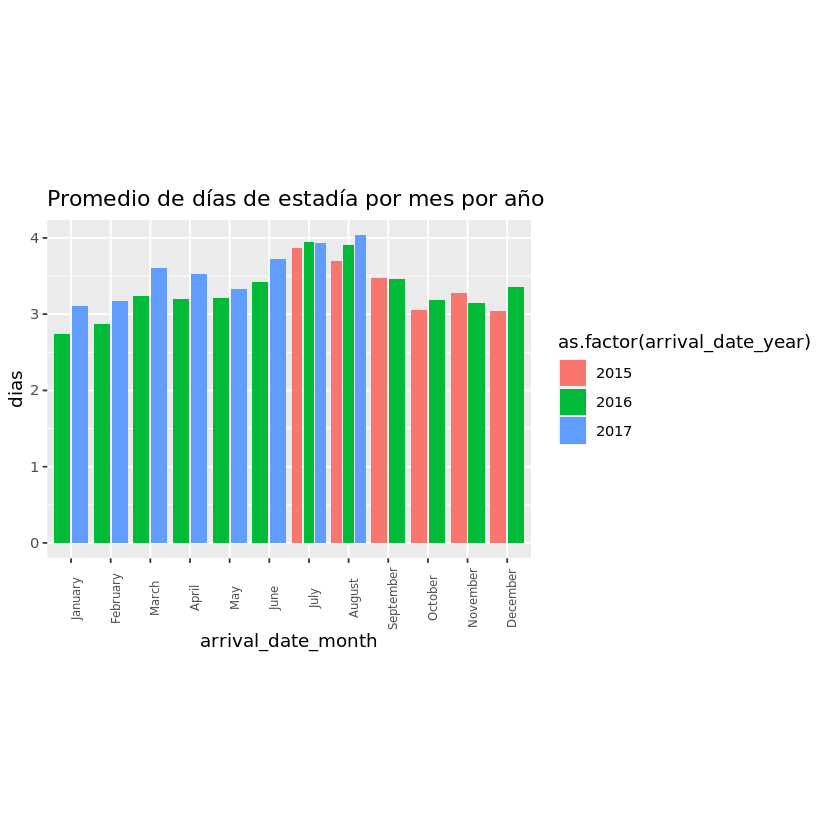

In [45]:
df['stays_nights'] = df$stays_in_week_nights + df$stays_in_weekend_nights
tmp = df %>% group_by(arrival_date_year, arrival_date_month) %>% summarise(dias=mean(stays_nights))
arr_dat_year <- ggplot(tmp) +
    geom_bar(aes(x=arrival_date_month, y=dias, fill=as.factor(arrival_date_year)), stat="identity", position = "dodge2")+
    ggtitle("Promedio de días de estadía por mes por año")+
    theme(aspect.ratio = 0.7, axis.text.x = element_text(size = 7, angle = 90))
# png("arr_date.png")
# print(arr_dat_year)
# dev.off()
arr_dat_year

# Esto al final
<br><br><br><br><br><br><br><br><br>
## Próximos desafíos
En base a todas las gráficas mostradas anteriormente se plantean los siguientes pasos a seguir:
* Primero se debe limpiar los datos que no aportan al modelo. Entre varias razones, se puede mencionar la poca variabilidad, la alta correlación, la correlación perfecta o la alta cantidad de valores nulos.
* Se debe entender los valores de manera de poder extraer información adicional a la presente en las variables actuales, como utilizar operaciones sobre más de una columna.
* 

## Aportes personales

* Sebastián Flores:
<ol>
    <li>Estudio inicial de variables NULL, Segmentación por tipo de dato, estudio balanceo de datos.</li>
</ol>
* Benjamín Herrera:
<ol>
    <li>hola</li>
</ol>
* Diego Reyes:
<ol>
    <li>hola</li>
</ol>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e23c1f0e-bfe3-498a-84d7-0763e07e74ab' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>